<a href="https://colab.research.google.com/github/mcnica89/DNNs/blob/main/Simulating_DNNs_on_initialization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Import packages we use!  mostly jax (which is like numpy but beefed up)
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from jax import nn
import time
import math

import pandas as pd  #data frames for use in plotting
from plotnine import * #this is the ggplot package!

In [2]:
#These helper functions involve the L2 norm ||v||^2 of a vector, 
# BUT work assuming that you have many vectors in a single array, so that 
# v is of shape (dim, N_samples) where dim is the dimension and N_samples is the number of samples 
def norm2(v):
  return jnp.einsum("is,is->s",v,v)

def norm(v):
 return jnp.sqrt(norm2(v))

def unit_vector(v):
  return v/norm(v)

In [3]:
N_width = 2**6 #network width = number of neurons per layer
N_depth = 2**2 #network depth = number of layers
N_samples =  int(2**30/(N_width**2 * N_depth)) #number of samples to run simulatenously
#(we use a number of samples that grows/shrinks with depth and width so that we can automatically fill the computers memory with samples)

key = random.PRNGKey(int(time.time())) #random key for generating random numbers
  
#Initial input vector is a random unit vector
input = unit_vector(random.normal(key,(N_width,N_samples), dtype=jnp.float64))
keys = random.split(key, N_depth) #get a random key used to generate each layer of the network

z = input
for layer in range(N_depth): 
  #Setup the weight matrix and normalize by the fan-in
  W = random.normal(keys[layer],(N_width,N_width,N_samples),dtype=jnp.float64)*math.sqrt(2/N_width)

  phi = nn.relu(z) #vector after applying the activation function
  z = jnp.einsum("ijs,js->is",W,phi) #Apply the weight matrix W in each sample

output = z #reutrn a vector of shape (N_width, N_samples) with the outputs!

#Plotting the output

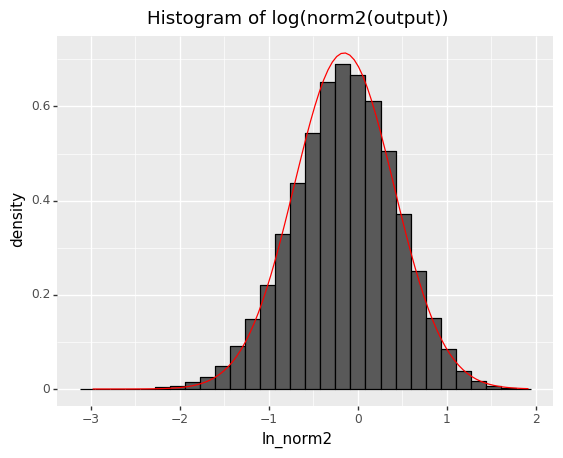

Mean norm2 of output is 1.0018789768218994 using 65536 samples


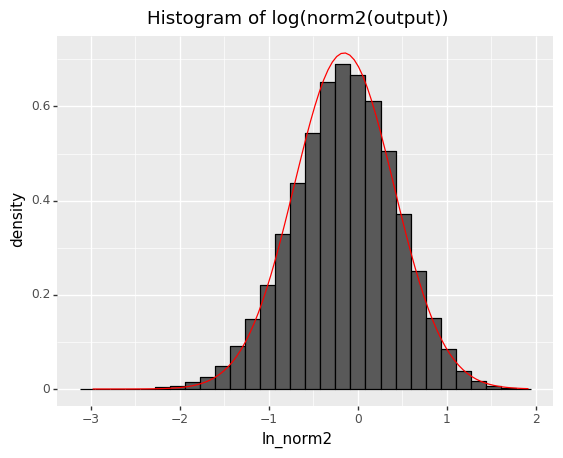

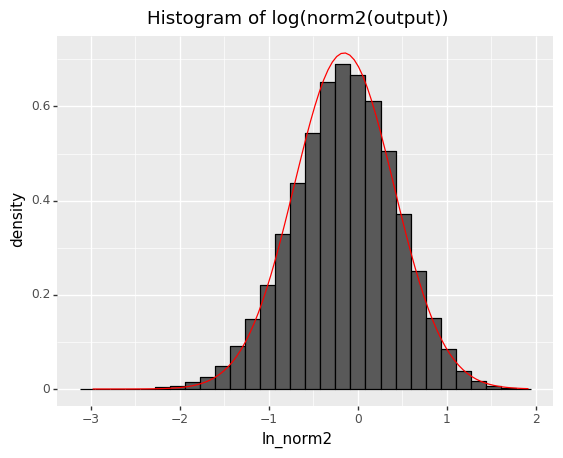

In [7]:
def NormalCDF(mean,var,x):
  return 0.5*math.erfc(-(x-mean)/math.sqrt(2*var))

def NormalPDF(mean,var,x):
  return math.exp(-(x-mean)**2/(2*var))/math.sqrt(2*math.pi*var)

output_norm2 = norm2(output) #take the norm of each simulation to get a vector of shape (N_samples,) with the output
print(f'Mean norm2 of output is {jnp.mean(output_norm2)} using {N_samples} samples')

df = pd.DataFrame(jnp.log(output_norm2),columns=['ln_norm2']) #load data into a DataFrame object
plot = (
       ggplot(df, aes(x='ln_norm2')) +
       labs(title='Histogram of log(norm2(output))') +
       geom_histogram(aes(y='..density..'), color='black', bins=30) +
       stat_function(fun=lambda x: NormalPDF(-2.5*N_depth/N_width,5*N_depth/N_width,x), color='red')
)

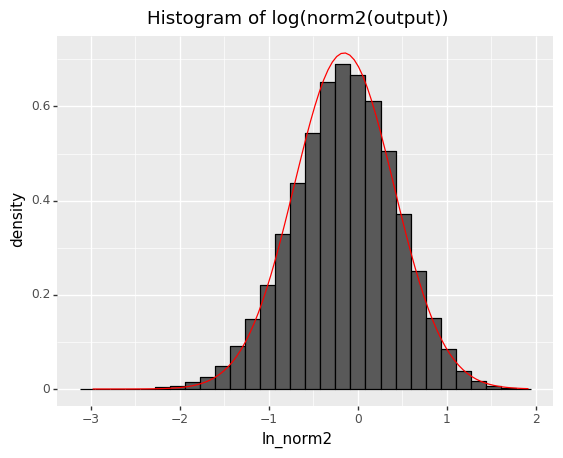

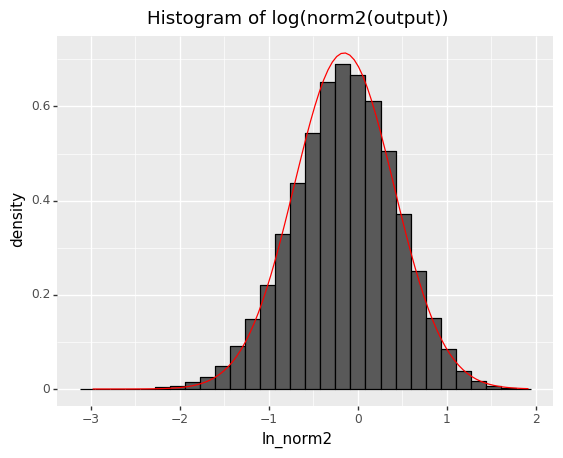

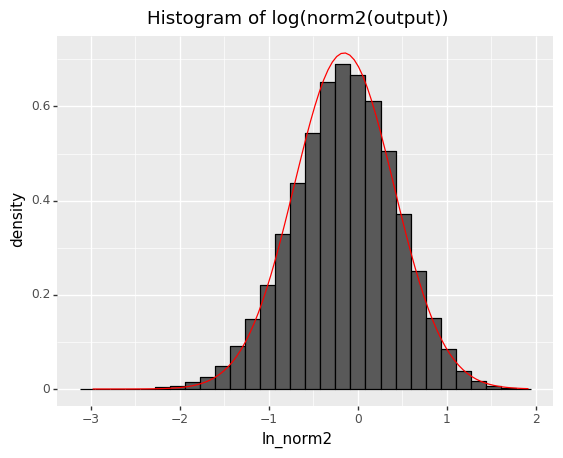

<ggplot: (8755844583557)>


In [8]:
print(plot)